In [97]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
spark = SparkSession.builder.master('local[*]').appName('Classificacao_Spark').getOrCreate()

23/06/27 21:52:48 WARN Utils: Your hostname, enricolm-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.233.129 instead (on interface ens33)
23/06/27 21:52:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/27 21:52:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
dados = spark.read.csv('/home/enricolm/Documents/Pyspark_classificacao/base de dados/dados_clientes.csv',
                    sep = ',',
                    inferSchema = True,
                    header = True
                       )

In [4]:
dados.show()

+---+-----+----------+-------+-----------+---------------+------------+------------------------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------+----------------+-------------+
| id|Churn|Mais65anos|Conjuge|Dependentes|MesesDeContrato|TelefoneFixo|MaisDeUmaLinhaTelefonica|   Internet|   SegurancaOnline|      BackupOnline| SeguroDispositivo|    SuporteTecnico|           TVaCabo|   StreamingFilmes|TipoContrato|ContaCorreio| MetodoPagamento|MesesCobrados|
+---+-----+----------+-------+-----------+---------------+------------+------------------------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------+----------------+-------------+
|  0|  Nao|         0|    Sim|        Nao|              1|         Nao|    SemServicoTelefonico|        DSL|               Nao|               Sim|              

In [5]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Churn: string (nullable = true)
 |-- Mais65anos: integer (nullable = true)
 |-- Conjuge: string (nullable = true)
 |-- Dependentes: string (nullable = true)
 |-- MesesDeContrato: integer (nullable = true)
 |-- TelefoneFixo: string (nullable = true)
 |-- MaisDeUmaLinhaTelefonica: string (nullable = true)
 |-- Internet: string (nullable = true)
 |-- SegurancaOnline: string (nullable = true)
 |-- BackupOnline: string (nullable = true)
 |-- SeguroDispositivo: string (nullable = true)
 |-- SuporteTecnico: string (nullable = true)
 |-- TVaCabo: string (nullable = true)
 |-- StreamingFilmes: string (nullable = true)
 |-- TipoContrato: string (nullable = true)
 |-- ContaCorreio: string (nullable = true)
 |-- MetodoPagamento: string (nullable = true)
 |-- MesesCobrados: double (nullable = true)



In [6]:
dados.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  Sim| 5174|
|  Nao| 5174|
+-----+-----+



In [7]:
dados.withColumn('Conjuge',f.when(f.col('Conjuge') == 'Sim', 1).otherwise(0)).show()

+---+-----+----------+-------+-----------+---------------+------------+------------------------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------+----------------+-------------+
| id|Churn|Mais65anos|Conjuge|Dependentes|MesesDeContrato|TelefoneFixo|MaisDeUmaLinhaTelefonica|   Internet|   SegurancaOnline|      BackupOnline| SeguroDispositivo|    SuporteTecnico|           TVaCabo|   StreamingFilmes|TipoContrato|ContaCorreio| MetodoPagamento|MesesCobrados|
+---+-----+----------+-------+-----------+---------------+------------+------------------------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------+----------------+-------------+
|  0|  Nao|         0|      1|        Nao|              1|         Nao|    SemServicoTelefonico|        DSL|               Nao|               Sim|              

In [8]:
colunasBinarias = [
    'Churn',
    'Conjuge',
    'Dependentes',
    'TelefoneFixo',
    'MaisDeUmaLinhaTelefonica',
    'SegurancaOnline',
    'BackupOnline',
    'SeguroDispositivo',
    'SuporteTecnico',
    'TVaCabo',
    'StreamingFilmes',
    'ContaCorreio'
]

In [9]:
dados_transformados = [f.when(f.col(c) == 'Sim',1).otherwise(0).alias(c)for c in colunasBinarias]

In [10]:
for col in reversed(dados.columns):
    if col not in colunasBinarias:
        dados_transformados.insert(0,col)

dados_transformados

['id',
 'Mais65anos',
 'MesesDeContrato',
 'Internet',
 'TipoContrato',
 'MetodoPagamento',
 'MesesCobrados',
 Column<'CASE WHEN (Churn = Sim) THEN 1 ELSE 0 END AS Churn'>,
 Column<'CASE WHEN (Conjuge = Sim) THEN 1 ELSE 0 END AS Conjuge'>,
 Column<'CASE WHEN (Dependentes = Sim) THEN 1 ELSE 0 END AS Dependentes'>,
 Column<'CASE WHEN (TelefoneFixo = Sim) THEN 1 ELSE 0 END AS TelefoneFixo'>,
 Column<'CASE WHEN (MaisDeUmaLinhaTelefonica = Sim) THEN 1 ELSE 0 END AS MaisDeUmaLinhaTelefonica'>,
 Column<'CASE WHEN (SegurancaOnline = Sim) THEN 1 ELSE 0 END AS SegurancaOnline'>,
 Column<'CASE WHEN (BackupOnline = Sim) THEN 1 ELSE 0 END AS BackupOnline'>,
 Column<'CASE WHEN (SeguroDispositivo = Sim) THEN 1 ELSE 0 END AS SeguroDispositivo'>,
 Column<'CASE WHEN (SuporteTecnico = Sim) THEN 1 ELSE 0 END AS SuporteTecnico'>,
 Column<'CASE WHEN (TVaCabo = Sim) THEN 1 ELSE 0 END AS TVaCabo'>,
 Column<'CASE WHEN (StreamingFilmes = Sim) THEN 1 ELSE 0 END AS StreamingFilmes'>,
 Column<'CASE WHEN (ContaCorr

In [11]:
dados_transformados = dados.select(dados_transformados)

In [12]:
dados_transformados.show()

+---+----------+---------------+-----------+------------+----------------+-------------+-----+-------+-----------+------------+------------------------+---------------+------------+-----------------+--------------+-------+---------------+------------+
| id|Mais65anos|MesesDeContrato|   Internet|TipoContrato| MetodoPagamento|MesesCobrados|Churn|Conjuge|Dependentes|TelefoneFixo|MaisDeUmaLinhaTelefonica|SegurancaOnline|BackupOnline|SeguroDispositivo|SuporteTecnico|TVaCabo|StreamingFilmes|ContaCorreio|
+---+----------+---------------+-----------+------------+----------------+-------------+-----+-------+-----------+------------+------------------------+---------------+------------+-----------------+--------------+-------+---------------+------------+
|  0|         0|              1|        DSL| Mensalmente|BoletoEletronico|        29.85|    0|      1|          0|           0|                       0|              0|           1|                0|             0|      0|              0|      

In [13]:
dados_transformados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Mais65anos: integer (nullable = true)
 |-- MesesDeContrato: integer (nullable = true)
 |-- Internet: string (nullable = true)
 |-- TipoContrato: string (nullable = true)
 |-- MetodoPagamento: string (nullable = true)
 |-- MesesCobrados: double (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- Conjuge: integer (nullable = false)
 |-- Dependentes: integer (nullable = false)
 |-- TelefoneFixo: integer (nullable = false)
 |-- MaisDeUmaLinhaTelefonica: integer (nullable = false)
 |-- SegurancaOnline: integer (nullable = false)
 |-- BackupOnline: integer (nullable = false)
 |-- SeguroDispositivo: integer (nullable = false)
 |-- SuporteTecnico: integer (nullable = false)
 |-- TVaCabo: integer (nullable = false)
 |-- StreamingFilmes: integer (nullable = false)
 |-- ContaCorreio: integer (nullable = false)



In [14]:
internet = dados_transformados.groupBy('id').pivot('Internet').agg(f.lit(1)).na.fill(0)

In [15]:
TipoContrato = dados_transformados.groupBy('id').pivot('TipoContrato').agg(f.lit(1)).na.fill(0)

In [16]:
MetodoPagamento = dados_transformados.groupBy('id').pivot('MetodoPagamento').agg(f.lit(1)).na.fill(0)

In [17]:
dataset = dados_transformados\
    .join(internet, 'id' , how = 'inner')\
    .join(MetodoPagamento, 'id', how = 'inner')\
    .join(TipoContrato,'id' , how = 'inner')\
    .select('*',
        f.col('DSL').alias('Internet_DSL'), 
        f.col('FibraOptica').alias('Internet_FibraOptica'), 
        f.col('Nao').alias('Internet_Nao'), 
        f.col('Mensalmente').alias('TipoContrato_Mensalmente'), 
        f.col('UmAno').alias('TipoContrato_UmAno'), 
        f.col('DoisAnos').alias('TipoContrato_DoisAnos'), 
        f.col('DebitoEmConta').alias('MetodoPagamento_DebitoEmConta'), 
        f.col('CartaoCredito').alias('MetodoPagamento_CartaoCredito'), 
        f.col('BoletoEletronico').alias('MetodoPagamento_BoletoEletronico'), 
        f.col('Boleto').alias('MetodoPagamento_Boleto'))\
    .drop(
        'Internet', 'TipoContrato', 'MetodoPagamento', 'DSL', 
        'FibraOptica', 'Nao', 'Mensalmente', 'UmAno', 'DoisAnos', 
        'DebitoEmConta', 'CartaoCredito', 'BoletoEletronico', 'Boleto'
    )

In [18]:
dataset.show()

23/06/27 21:53:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+----------+---------------+-----------------+-----+-------+-----------+------------+------------------------+---------------+------------+-----------------+--------------+-------+---------------+------------+------------+--------------------+------------+------------------------+------------------+---------------------+-----------------------------+-----------------------------+--------------------------------+----------------------+
|  id|Mais65anos|MesesDeContrato|    MesesCobrados|Churn|Conjuge|Dependentes|TelefoneFixo|MaisDeUmaLinhaTelefonica|SegurancaOnline|BackupOnline|SeguroDispositivo|SuporteTecnico|TVaCabo|StreamingFilmes|ContaCorreio|Internet_DSL|Internet_FibraOptica|Internet_Nao|TipoContrato_Mensalmente|TipoContrato_UmAno|TipoContrato_DoisAnos|MetodoPagamento_DebitoEmConta|MetodoPagamento_CartaoCredito|MetodoPagamento_BoletoEletronico|MetodoPagamento_Boleto|
+----+----------+---------------+-----------------+-----+-------+-----------+------------+----------------------

In [19]:
dataset = dataset.withColumnRenamed('Churn', 'label')
x = dataset.columns
x.remove('label')
x.remove('id')

In [20]:
x

['Mais65anos',
 'MesesDeContrato',
 'MesesCobrados',
 'Conjuge',
 'Dependentes',
 'TelefoneFixo',
 'MaisDeUmaLinhaTelefonica',
 'SegurancaOnline',
 'BackupOnline',
 'SeguroDispositivo',
 'SuporteTecnico',
 'TVaCabo',
 'StreamingFilmes',
 'ContaCorreio',
 'Internet_DSL',
 'Internet_FibraOptica',
 'Internet_Nao',
 'TipoContrato_Mensalmente',
 'TipoContrato_UmAno',
 'TipoContrato_DoisAnos',
 'MetodoPagamento_DebitoEmConta',
 'MetodoPagamento_CartaoCredito',
 'MetodoPagamento_BoletoEletronico',
 'MetodoPagamento_Boleto']

In [21]:
assembler = VectorAssembler(inputCols=x, outputCol='features')

dataset_trans = assembler.transform(dataset).select('features','label')

In [22]:
dataset_trans.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(24,[1,2,11,12,13...|    1|
|(24,[1,2,3,5,6,8,...|    1|
|(24,[1,2,5,6,10,1...|    0|
|(24,[1,2,3,5,8,12...|    0|
|(24,[1,2,3,5,6,11...|    1|
|(24,[1,2,5,6,12,1...|    1|
|(24,[1,2,3,5,6,8,...|    0|
|(24,[1,2,5,6,15,1...|    0|
|(24,[1,2,3,5,7,8,...|    0|
|(24,[1,2,3,5,12,1...|    1|
|(24,[1,2,5,16,17,...|    0|
|(24,[1,2,5,8,12,1...|    0|
|(24,[1,2,3,5,6,11...|    1|
|(24,[1,2,5,6,13,1...|    0|
|(24,[1,2,5,6,8,11...|    1|
|(24,[0,1,2,3,5,6,...|    1|
|(24,[0,1,2,3,5,7,...|    0|
|(24,[1,2,5,8,14,1...|    1|
|(24,[1,2,5,16,19,...|    0|
|(24,[1,2,3,4,5,11...|    1|
+--------------------+-----+
only showing top 20 rows



In [23]:
train, test = dataset_trans.randomSplit([0.7,0.3])

In [24]:
train.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    1|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    1|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
|(24,[0,1,2,3,4,5,...|    0|
+--------------------+-----+
only showing top 20 rows



In [25]:
lr = LogisticRegression()

In [26]:
modelo_lr = lr.fit(train)

23/06/27 21:53:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [27]:
predicao = modelo_lr.transform(test)

In [28]:
predicao.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[3.16513527551650...|[0.95950096892494...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[0.70596100730779...|[0.66950807662079...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[1.07894977365756...|[0.74629518630726...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[0.87574443483475...|[0.70593958792340...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[-0.6669142749928...|[0.33918813020755...|       1.0|
|(24,[0,1,2,3,4,5,...|    1|[0.23677920215344...|[0.55891978227388...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[-0.3151355872120...|[0.42186169780287...|       1.0|
|(24,[0,1,2,3,4,5,...|    1|[0.39238074110504...|[0.59685568263798...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[-0.0369522623472...|[0.49076298546122...|       1.0|
|(24,[0,1,2,3,4,

In [29]:
valor_predicao = modelo_lr.summary

In [30]:
print("Acurácia: %f" % valor_predicao.accuracy)
print("Precisão: %f" % valor_predicao.precisionByLabel[1])
print("Recall: %f" % valor_predicao.recallByLabel[1])
print("F1: %f" % valor_predicao.fMeasureByLabel()[1])

Acurácia: 0.785184
Precisão: 0.770288
Recall: 0.814419
F1: 0.791739


In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plotar_matriz_conclusao(dataset):
    
    tp = dataset.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 1 )).count()
    tn = dataset.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 0 )).count()
    fn = dataset.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 1 )).count()
    fp = dataset.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 0 )).count()

    
    # Definir rótulos das classes
    labels = ['Negativo', 'Positivo']

    # Criar matriz de confusão
    matriz = np.array([[tn, fp], [fn, tp]])

    # Configurar o gráfico
    fig, ax = plt.subplots()
    im = ax.imshow(matriz, cmap='Blues')

    # Adicionar barra de cores
    cbar = ax.figure.colorbar(im, ax=ax)

    # Definir ticks e rótulos dos eixos
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Girar os rótulos dos eixos
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Adicionar valores na matriz
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, matriz[i, j], ha="center", va="center", color="black")

    # Definir título do gráfico
    ax.set_title("Matriz de Conclusão")

    # Mostrar o gráfico
    plt.show()


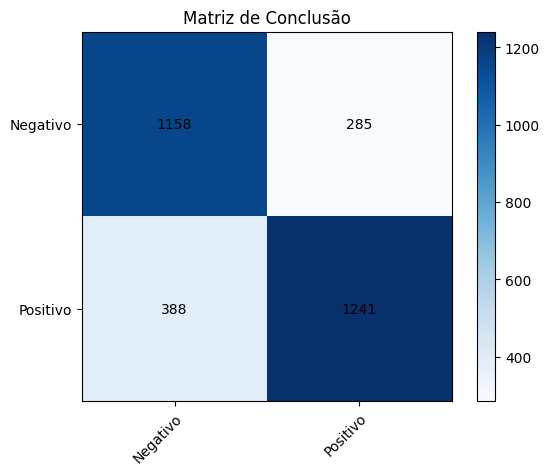

In [32]:
plotar_matriz_conclusao(predicao)

In [33]:
dtc = DecisionTreeClassifier()

In [34]:
model_tree = dtc.fit(train)

In [35]:
valor_predicao_dtc = model_tree.transform(train)
valor_predicao_dtc.show()

+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0| [667.0,107.0]|[0.86175710594315...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [667.0,107.0]|[0.86175710594315...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|   [29.0,16.0]|[0.64444444444444...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [244.0,211.0]|[0.53626373626373...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[423.0,2130.0]|[0.16568742655699...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[423.0,2130.0]|[0.16568742655699...|       1.0|
|(24,[0,1,2,3,4,5,...|    0| [496.0,196.0]|[0.71676300578034...|       0.0|
|(24,[0,1,2,3,4,5,...|    1| [244.0,211.0]|[0.53626373626373...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[423.0,2130.0]|[0.16568742655699...|       1.0|
|(24,[0,1,2,3,4,5,...|    0| [667.0,107.0]|[0.86175710594315...|       0.0|
|(24,[0,1,2,

In [36]:
valor_predicao_dtc.count()

7276

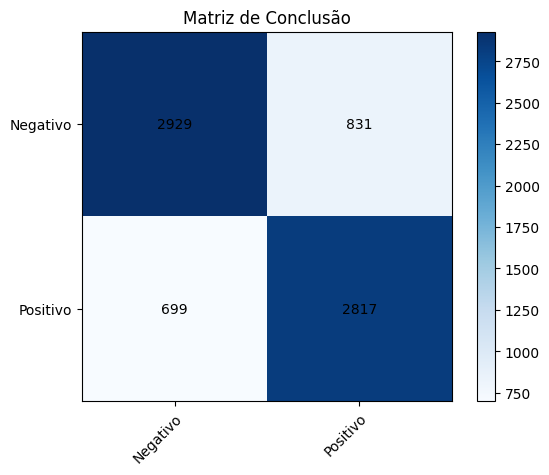

In [37]:
plotar_matriz_conclusao(valor_predicao_dtc)

In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def plot_evaluetor(predicao):
    mce = MulticlassClassificationEvaluator()
    acurracy = mce.evaluate(predicao,{mce.metricName : 'accuracy'})
    print(f'Acuracia: {round(acurracy,4)}')


plot_evaluetor(valor_predicao_dtc)

Acuracia: 0.7897


In [39]:
print("Acurácia: %f" % valor_predicao.accuracy)

Acurácia: 0.785184


In [40]:
valor_teste_dtc = model_tree.transform(test)
plot_evaluetor(valor_teste_dtc)

Acuracia: 0.7865


In [41]:
rfc = RandomForestClassifier()

In [42]:
modelo_rfc = rfc.fit(train)

In [43]:
valor_treino_rfc = modelo_rfc.transform(train)
valor_test_rfc = modelo_rfc.transform(test)

In [44]:
valor_treino_rfc.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[16.5688865782975...|[0.82844432891487...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[15.6888804779063...|[0.78444402389531...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[8.26366366558474...|[0.41318318327923...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[9.56727184929953...|[0.47836359246497...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[4.79731899483596...|[0.23986594974179...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[4.68022730918751...|[0.23401136545937...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[13.0014144110176...|[0.65007072055088...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[9.33494861697630...|[0.46674743084881...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[4.68022730918751...|[0.23401136545937...|       1.0|
|(24,[0,1,2,3,4,

In [45]:
plot_evaluetor(valor_treino_rfc)

Acuracia: 0.7923


In [46]:
plot_evaluetor(valor_test_rfc)

Acuracia: 0.7858


In [47]:
grid = ParamGridBuilder()\
    .addGrid(dtc.maxDepth,[2,8,16])\
    .addGrid(dtc.maxBins,[10,26,38])\
    .build()



In [48]:
evaluetor = MulticlassClassificationEvaluator()

dtc = CrossValidator(
    estimator=dtc,
    estimatorParamMaps=grid,
    evaluator= evaluetor,
    numFolds=3
)

In [49]:
model_tree_cv = dtc.fit(train)

In [50]:
predicao_dtc_cv = model_tree_cv.transform(train)

In [51]:
plot_evaluetor(predicao_dtc_cv)

Acuracia: 0.9531


In [52]:
predicao_dtc_cv_teste = model_tree_cv.transform(test)
plot_evaluetor(predicao_dtc_cv_teste)

Acuracia: 0.7897


In [54]:
grid = ParamGridBuilder()\
    .addGrid(rfc.maxDepth,[4,8,22])\
    .addGrid(rfc.maxBins,[14,25,36])\
    .addGrid(rfc.numTrees, [10, 20, 50])\
    .build()

In [55]:
rfc = CrossValidator(
    estimator=rfc,
    estimatorParamMaps=grid,
    evaluator=evaluetor,
    numFolds=3
)

In [56]:
model_rfc = rfc.fit(train)

23/06/27 22:03:14 WARN DAGScheduler: Broadcasting large task binary with size 1432.3 KiB
23/06/27 22:03:19 WARN DAGScheduler: Broadcasting large task binary with size 1401.0 KiB
23/06/27 22:03:24 WARN DAGScheduler: Broadcasting large task binary with size 1428.9 KiB
23/06/27 22:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1189.1 KiB
23/06/27 22:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1371.6 KiB
23/06/27 22:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1514.8 KiB
23/06/27 22:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1613.5 KiB
23/06/27 22:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1682.2 KiB
23/06/27 22:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1728.0 KiB
23/06/27 22:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1755.9 KiB
23/06/27 22:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1616.0 KiB
23/06/27 22:03:27 WAR

In [57]:
predicao_rfc_cv = modelo_rfc.transform(test)

In [58]:
predicao_rfc_cv.summary

<bound method DataFrame.summary of DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]>

In [59]:
plot_evaluetor(predicao_rfc_cv)

Acuracia: 0.7858


In [69]:
teste_melhor_rfc_cv = model_rfc.bestModel

In [70]:
teste_melhor_rfc_cv.getMaxDepth()

22

In [71]:
teste_melhor_rfc_cv.getMaxBins()

36

In [72]:
teste_melhor_rfc_cv.getNumTrees

50

In [73]:
rfc_best = RandomForestClassifier(maxDepth=22,maxBins=36,numTrees=50)

In [74]:
model_rfc_best = rfc_best.fit(train)

23/06/27 22:21:35 WARN DAGScheduler: Broadcasting large task binary with size 1488.8 KiB
23/06/27 22:21:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/06/27 22:21:36 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/06/27 22:21:37 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/06/27 22:21:38 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
23/06/27 22:21:39 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/06/27 22:21:40 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
23/06/27 22:21:41 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
23/06/27 22:21:42 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
23/06/27 22:21:43 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/06/27 22:21:44 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
23/06/27 22:21:46 WARN DAGScheduler: Broadcasting

In [75]:
predicao_rfc_best = model_rfc_best.transform(test)

In [77]:
plot_evaluetor(predicao_rfc_best)

23/06/27 22:22:32 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


Acuracia: 0.8317


In [78]:
novo_cliente = [{
    'Mais65anos': 0,
    'MesesDeContrato': 1,
    'MesesCobrados': 45.30540797610398,
    'Conjuge': 0,
    'Dependentes': 0,
    'TelefoneFixo': 0,
    'MaisDeUmaLinhaTelefonica': 0,
    'SegurancaOnline': 0,
    'BackupOnline': 0,
    'SeguroDispositivo': 0,
    'SuporteTecnico': 0,
    'TVaCabo': 1,
    'StreamingFilmes': 1,
    'ContaCorreio': 1,
    'Internet_DSL': 1,
    'Internet_FibraOptica': 0,
    'Internet_Nao': 0,
    'TipoContrato_Mensalmente': 1,
    'TipoContrato_UmAno': 0,
    'TipoContrato_DoisAnos': 0,
    'MetodoPagamento_DebitoEmConta': 0,
    'MetodoPagamento_CartaoCredito': 0,
    'MetodoPagamento_BoletoEletronico': 1,
    'MetodoPagamento_Boleto': 0
}]

In [79]:
novo_cliente_dataset = spark.createDataFrame(novo_cliente)

In [81]:
novo_cliente_dataset.show()

+------------+-------+------------+-----------+------------+--------------------+------------+----------+------------------------+-----------------+---------------+----------------------+--------------------------------+-----------------------------+-----------------------------+---------------+-----------------+---------------+--------------+-------+------------+---------------------+------------------------+------------------+
|BackupOnline|Conjuge|ContaCorreio|Dependentes|Internet_DSL|Internet_FibraOptica|Internet_Nao|Mais65anos|MaisDeUmaLinhaTelefonica|    MesesCobrados|MesesDeContrato|MetodoPagamento_Boleto|MetodoPagamento_BoletoEletronico|MetodoPagamento_CartaoCredito|MetodoPagamento_DebitoEmConta|SegurancaOnline|SeguroDispositivo|StreamingFilmes|SuporteTecnico|TVaCabo|TelefoneFixo|TipoContrato_DoisAnos|TipoContrato_Mensalmente|TipoContrato_UmAno|
+------------+-------+------------+-----------+------------+--------------------+------------+----------+------------------------+----

In [84]:
novo_assembler= assembler.transform(novo_cliente_dataset).select('features')

In [85]:
novo_assembler.show()

+--------------------+
|            features|
+--------------------+
|(24,[1,2,11,12,13...|
+--------------------+



In [87]:
valor_final = model_rfc_best.transform(novo_assembler)

In [90]:
valor_final.show()

23/06/27 22:37:10 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
23/06/27 22:37:10 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(24,[1,2,11,12,13...|[1.96892459683983...|[0.03937849193679...|       1.0|
+--------------------+--------------------+--------------------+----------+

